In [1]:
# MNIST test dataset
from tensorflow.keras.datasets import mnist

In [2]:
# import helper library
import matplotlib.pyplot as plt
import numpy as np

In [3]:
# import dataset
(trainx, trainy), (testx, testy) = mnist.load_data()

In [4]:
# seeing the shapes of imported dataset
trainx.shape, trainy.shape, testx.shape, testy.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

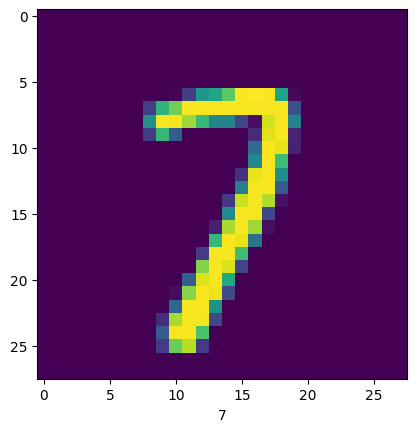

In [5]:
def choose_random_train():
    random_number = np.random.randint(0, 60000)
    sample_X = trainx[random_number]
    sample_y = trainy[random_number]
    return sample_X, sample_y, random_number

random_X, random_y, _ = choose_random_train()
plt.imshow(random_X)
plt.xlabel(random_y)

cursor = 0
def batch_generator_1000():
    global cursor
    print(cursor)
    x_batch = trainx[cursor:cursor+1000]
    y_batch = trainy[cursor:cursor+1000]
    cursor += 1000
    cursor %= 60000
    return x_batch, y_batch

# aax, aay = batch_generator_1000()
# aax.shape, aay.shape

### Making the layers

##### Layers
- Each layers maintains following associated datatypes:
    - Information types
        - name: Name of the layer
        - parameters_count: Number of parameters of the layer
    - Useful types
        - Depends on the type of layer:
            - Eg: For weights layer, it's the weight matrix
            - Eg: For bias layer, it's the bias vector
            - Eg: For the activation layer, it is nothing
        - They can be abstracted away for the user of the layer

- Each layer should have the following functions
    - Apply (input) -> output
        - It applies the layer's operation to it's input to give an output
    - Input gradient (output gradient, input value, output value) -> gradient values for input
        - It calculates the gradient for the input given the gradient values for the output.
        - It takes the output gradient values, it's input values and it's output values, if it saves the computations
    - Parameter gradient (output gradient, input value, output value) -> gradient values for parameters
        - It calculates the gradient for the parameters using the output gradients, input values and output values
        - If the layer doesn't have any parameters, it has to output zero (because we will sum the gradients, and we need something to sum it)
    - dummy gradient () -> a zero of shape of parameters
        - a zero gradient value of shape of the parameters
    - learn (parameter gradient, learning rate)
        - It modifies the parameter given the gradient of the parameters and the learning rate

In [6]:
# helper function
def expand_dims_and_transpose(x):
    return np.transpose(np.expand_dims(x, 0))
def expand_dims(x):
    return np.expand_dims(x, 0)

# layers
class Flattener:
    def __init__(self, shape):
        self.name = f"Flattener                 : {shape} to {np.prod(shape)}\n"
        self.param_count = 0

        self.from_shape = shape
    
    def apply(self, input_value):
        return np.ndarray.flatten(input_value)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return np.ndarray.reshape(output_gradient, self.from_shape)
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Scaler:
    def __init__(self, scale_factor):
        self.name = f"Scaler with scale factor {scale_factor}"
        self.param_count = 0

        self.scale_factor = scale_factor
    
    def apply(self, input_value):
        return self.scale_factor * input_value
    
    def input_gradient(self, output_gradient, input_value=None, output_value = None):
        return self.scale_factor * output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class Weights:
    def __init__(self, input_size, output_size):
        self.name = f"Weights layer             : {input_size} to {output_size}"
        self.param_count = input_size * output_size
        
        # We create a transposed weights because input is a row vector
        self.weights = np.random.rand(input_size, output_size) - .5

    def apply(self, input_value):
        return np.matmul(input_value, self.weights)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        transposed_output_gradient = expand_dims_and_transpose(output_gradient)
        return np.transpose(np.matmul(self.weights, transposed_output_gradient))[0,:]
    
    def parameter_gradient(self, output_gradient, input_value, output_value=None):
        transposed_input = expand_dims_and_transpose(input_value)
        # print(np.shape(transposed_input), np.shape(output_gradient))
        return np.matmul(transposed_input, expand_dims(output_gradient))
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.weights))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.weights -= learning_rate * parameter_gradient_value

class Biases:
    def __init__(self, input_size):
        self.name = f"Biases layer              : {input_size}"
        self.param_count = input_size

        # We create a row vector of biases because input is a row vector
        self.biases = np.random.rand(input_size) - .5
    
    def apply(self, input_value):
        return input_value + self.biases
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def parameter_gradient(self, output_gradient, input_value=None, output_value=None):
        return output_gradient
    
    def dummy_gradient(self):
        return np.zeros(np.shape(self.biases))
    
    def learn(self, parameter_gradient_value, learning_rate):
        self.biases -= learning_rate * parameter_gradient_value

class ReluActivation:
    def __init__(self):
        self.name = f"ReLU Activation\n"
        self.param_count = 0

        # we create a vectorized function for activaton
        self.activation_function = np.vectorize(lambda x: 0 if x < 0 else x)
        # similarly we create a vectorized function for gradient
        self.gradient_function = np.vectorize(lambda x: 0 if x < 0 else 1)
    
    def apply(self, input_value):
        return self.activation_function(input_value)
    
    def input_gradient(self, output_gradient, input_value, output_value=None):
        return np.multiply(output_gradient, self.gradient_function(input_value))
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

class SoftmaxActivationOnlyWhenNeeded:
    def __init__(self, need=False):
        self.name = f"Softmax Activation, Activated:{need}\n"
        self.param_count = 0
        self.need = need
    
    def actual_apply(self, input_value):
        maximum = np.max(input_value)
        new_data = np.exp(input_value-maximum)
        denominator = np.sum(new_data)
        return new_data/denominator
        
    
    def apply(self, input_value):
        if self.need:
            return self.actual_apply(input_value)
        return input_value
    
    def actual_input_gradient(self, output_gradient, input_value, output_value=None):
        size = len(output_value)
        if output_value == None:
            output_value = self.actual_apply(input_value)
        magic_matrix = np.diag(output_value) - np.matmul(np.transpose(output_value), output_value)
        return np.matmul(output_gradient, magic_matrix)
    
    def input_gradient(self, output_gradient, input_value=None, output_value=None):
        if self.need:
            return self.actual_input_gradient(output_gradient, input_value, output_value)
        return output_gradient
    
    def parameter_gradient(self, output_gradient=None, input_value=None, output_value=None):
        return 0
    
    def dummy_gradient(self):
        return 0
    
    def learn(self, parameter_gradient_value=None, learning_rate=None):
        pass

In [7]:
# dataset transformation
class OneHotEncoder:
    def __init__(self, input_size):
        self.name = "One hot encoder of size : {input_size}"
        self.size = input_size
    
    def __call__(self, number):
        output = np.zeros(self.size)
        output[number] = 1
        return output

class Identity:
    def __init__(self):
        self.name = "None"
    def __call__(self, x):
        return x

### Making the Loss Function
##### Loss function
- Each loss function has following data types
    - Name: Name of the loss function.

- Each loss function should implement the following methods
    - Apply(prediction, ground_truth) -> loss value
        - It calculates the required loss function.
    - Call(prediction, gournd_truth) -> loss value
        - It calls the apply function under the hood.
    - Prediction gradient(prediction, ground_truth) -> gradient values for output
        - It returns the gradient value for the loss wrt prediction value.
        - To calculate it, it is supplied with the prediction value and the ground truth.

In [8]:
def softmax_function(input_value):
    maximum = np.max(input_value)
    new_data = np.exp(input_value-maximum)
    denominator = np.sum(new_data)
    return new_data/denominator

class CrossEntropyLossFunctionFromLogits:
    def __init__(self):
        self.name = "Cross Entropy Loss Function from the logits"
        self.loss_function = softmax_function
    
    def apply(self, prediction, ground_truth):
        softmax_output = softmax_function(prediction)
        return np.sum(np.multiply(-ground_truth, np.log(prediction)))
    
    def __call__(self, prediction, ground_truth):
        return self.apply(prediction, ground_truth)
    
    def prediction_gradient(self, prediction, ground_truth):
        return np.sum(ground_truth)*softmax_function(prediction) - ground_truth


### Making the model
##### Sequential model
- Each sequential model should have following data types
    - Information types
        - Name: Name of the model
    - Useful types
        - Layers: A list of the sequential layers
        - Loss function : The function that defines the loss
        - Dataset transformation : The transformation that is applied to the output of the dataset

        - Cumulative parameter gradients for all layers
        - 
- Each sequential model should implement the following methods
    - Informational / debug
        - representation
    - Useful
        - inference (input) -> output
            - For simple inference
        - Reset gradient
            - To reset the parameter gradients for all layers
        - forward propagation (input) -> output
            - For simple layer by layer forward propagation
            - Saves the input to each layer
            - Saves the last output
            - Prepares for the back propagation
        - Back propagation (output gradients) ->
            - Layer by layer back propagation calculating the parameter gradients at each step, and back-propagating the intermediate gradients
            - Sums the parameter gradients
        - input gradients
            - To calculate the gradient of the input given the gradient of the output

    

In [9]:
class Sequential_Model:
    def __init__(self, layers, loss_function, name="Sequential Model",  dataset_transformation=Identity()):
        self.name = name

        self.layers = layers
        self.loss_function = loss_function
        self.dataset_transformation = dataset_transformation
        self.param_count = sum(layer.param_count for layer in layers)
        self.last_loss = 0
    
    def inference(self, input_value):
        last_output = input_value
        for layer in self.layers:
            last_output = layer.apply(last_output)
        return last_output

    def __call__(self, input_value):
        return self.inference(input_value)

    def reset_gradient(self):
        self.parameter_gradients = [layer.dummy_gradient() for layer in self.layers]
        self.last_loss = 0
    
    def forward_propagation(self, input_value):
        self.last_inputs = []

        last_input = input_value
        self.last_inputs.append(last_input)
        for layer in self.layers:
            last_input = layer.apply(last_input)
            self.last_inputs.append(last_input)
        return last_input
    
    def back_propagation(self, output_gradient):
        last_gradient = output_gradient
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            input_value = self.last_inputs[i]
            output_value = self.last_inputs[i+1]
            parameter_gradient = layer.parameter_gradient(last_gradient, input_value, output_value)

            # save cumulative gradients
            self.parameter_gradients[i] += parameter_gradient

            last_gradient = layer.input_gradient(last_gradient, input_value, output_value)
        return last_gradient
    
    def input_gradients(self, output_gradient):
        last = len(self.layers()) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            output_gradient = layer.input_gradient(output_gradient, self.last_inputs[i], self.last_inputs[i+1])
        return output_gradient
    
    def see_dataset_for_training(self, input_dataset, output_dataset):
        ground_truth = self.dataset_transformation(output_dataset)
        prediction = self.forward_propagation(input_dataset)
        prediction_gradient = self.loss_function.prediction_gradient(prediction, ground_truth)
        last_gradient = self.back_propagation(prediction_gradient)
        self.last_loss += self.loss_function(prediction, ground_truth)
        return last_gradient

    def make_model_learn(self, learning_rate):
        last = len(self.layers) - 1
        for j, layer in enumerate(self.layers[::-1]):
            i = last - j
            layer.learn(self.parameter_gradients[i], learning_rate)
        pass

    def get_loss(self):
        return self.last_loss
    
    def __repr__(self):
        representation = f"{self.name}\n\n" 
        i = 0
        for layer in self.layers:
            i += 1
            representation += f"{i}. {layer.name}\n"
        representation += f"Total parameters = {self.param_count}\n"
        representation += f"Loss function = {self.loss_function.name}\n"
        return representation
        

        
            

In [10]:
# Building the model

MnistClassificationModel = Sequential_Model([
        Scaler(scale_factor=(1/255)),
        Flattener(shape=(28,28)),
    
        Weights(28*28, 512),
        Biases(512),
        ReluActivation(),
    
        Weights(512, 200),
        Biases(200),
        ReluActivation(),
    
        Weights(200, 50),
        Biases(50),
        ReluActivation(),
    
        Weights(50, 10),
        Biases(10),
    
        SoftmaxActivationOnlyWhenNeeded(),
    ],
    loss_function=CrossEntropyLossFunctionFromLogits(),
    name="Simple MNIST handwritten digit dataset classifier",
    dataset_transformation=OneHotEncoder(10)
)
# Reset cursor for training dataset if model is reinstiated
cursor = 0

print(MnistClassificationModel)
# output = MnistClassificationModel(random_X)
# print(output)
# print(softmax_function(output))


Simple MNIST handwritten digit dataset classifier

1. Flattener                 : (28, 28) to 784

2. Weights layer             : 784 to 512
3. Biases layer              : 512
4. ReLU Activation

5. Weights layer             : 512 to 200
6. Biases layer              : 200
7. ReLU Activation

8. Weights layer             : 200 to 50
9. Biases layer              : 50
10. ReLU Activation

11. Weights layer             : 50 to 10
12. Biases layer              : 10
13. Softmax Activation, Activated:False

Total parameters = 515080
Loss function = Cross Entropy Loss Function from the logits



Simple MNIST handwritten digit dataset classifier

1. Flattener                 : (28, 28) to 784

2. Weights layer             : 784 to 512
3. Biases layer              : 512
4. ReLU Activation

5. Weights layer             : 512 to 200
6. Biases layer              : 200
7. ReLU Activation

8. Weights layer             : 200 to 50
9. Biases layer              : 50
10. ReLU Activation

11. Weights layer             : 50 to 10
12. Biases layer              : 10
13. Softmax Activation, Activated:False

Total parameters = 515080
Loss function = Cross Entropy Loss Function from the logits



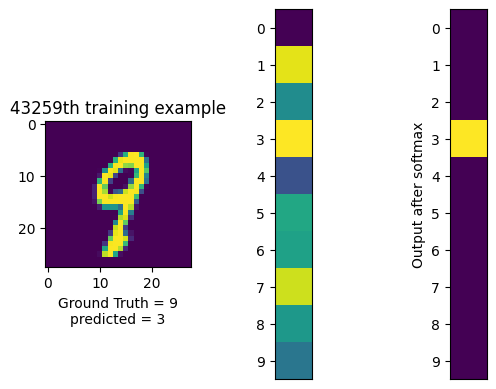

Logits output =  [-22869.85963682  19304.61388213  -1456.94724872  21130.28593655
 -11710.60048498   3438.26304407   2314.12277724  17737.32768972
    554.79695098  -5614.17161218]
Softmax output =  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_59933/4081460434.py:14: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))
/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_59933/4081460434.py:14: RuntimeWarning: invalid value encountered in log
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


In [11]:
def model_tester(print_outputs=False):
    rx, ry, n = choose_random_train()
    prediction = (MnistClassificationModel(rx))

    plt.subplot(1,3,1)
    plt.imshow(rx)
    plt.xlabel(f"Ground Truth = {ry}\npredicted = {np.argmax(prediction)}")
    plt.title(f"{n}th training example")

    plt.subplot(1,3,2)
    plt.imshow(np.reshape(prediction, (-1,1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    
    plt.subplot(1,3,3)
    plt.imshow(np.reshape(softmax_function(prediction), (-1, 1)))
    plt.yticks(np.arange(10))
    plt.xticks([])
    plt.ylabel("Output after softmax")

    plt.show()
    if print_outputs:
        print("Logits output = ", prediction)
        print("Softmax output = ", softmax_function(prediction))
        print("Loss value for this example = ", MnistClassificationModel.loss_function(prediction, ry))

print(MnistClassificationModel)
model_tester(True)


======= Epoch : 1 =======
Initial Loss = nan
40000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_59933/4081460434.py:14: RuntimeWarning: invalid value encountered in log
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


Loss after training = nan


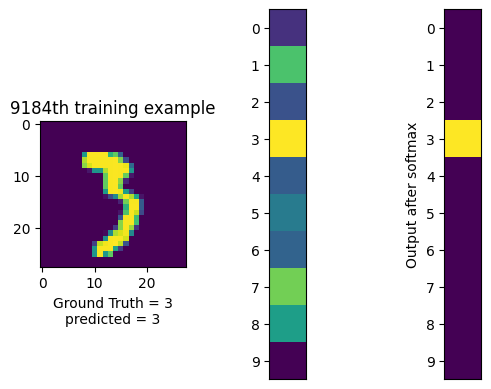

Logits output =  [-3272.54664971  2762.7475376  -2116.39800556  5741.56839592
 -1712.7322826   -392.28709287 -1394.94072989  3516.39730857
  1147.70017177 -4747.9225684 ]
Softmax output =  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 2 =======
Initial Loss = nan
41000


/var/folders/wt/vxbrslkx19g4hvktspqbdxcm0000gn/T/ipykernel_59933/4081460434.py:14: RuntimeWarning: overflow encountered in scalar negative
  return np.sum(np.multiply(-ground_truth, np.log(prediction)))


Loss after training = nan


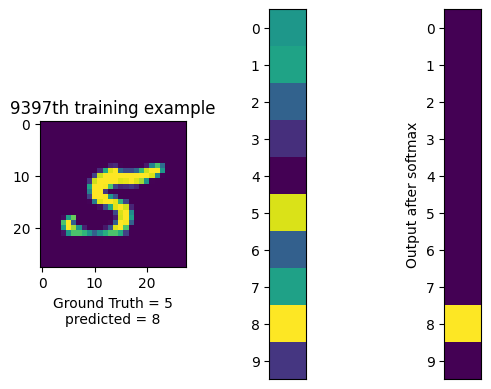

Logits output =  [3360.44221886 3649.12507981 2170.50769488 1156.81616559  409.95828291
 5662.45194995 2111.67658807 3590.46476274 5982.84707136 1301.66614618]
Softmax output =  [0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 0.00000000e+000 7.14770703e-140 0.00000000e+000 0.00000000e+000
 1.00000000e+000 0.00000000e+000]
Loss value for this example =  19433.727235164653

======= Epoch : 3 =======
Initial Loss = nan
42000
Loss after training = nan


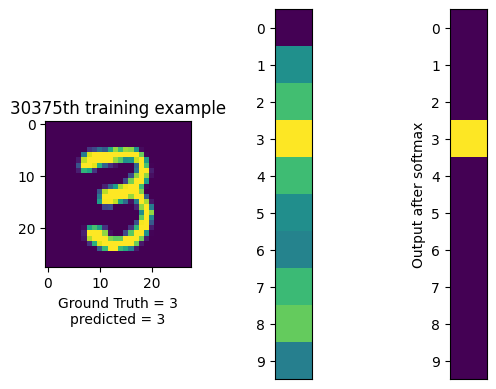

Logits output =  [-5906.60116069  -280.93140319  1893.44853911  5296.76393491
  1812.28648135  -366.92303107  -914.22936114  1713.66026651
  2627.50342049 -1091.65237253]
Softmax output =  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 4 =======
Initial Loss = nan
43000
Loss after training = nan


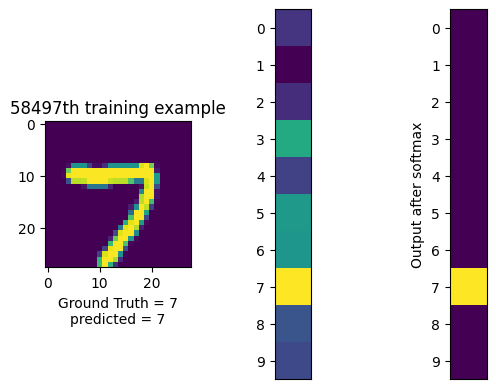

Logits output =  [-1184.4837102  -2908.42956399 -1395.02089666  4160.02297078
  -620.98754078  3301.50852847  3178.15820965  8641.84374719
   117.96510949  -360.02705361]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
Loss value for this example =  nan

======= Epoch : 5 =======
Initial Loss = nan
44000
Loss after training = nan


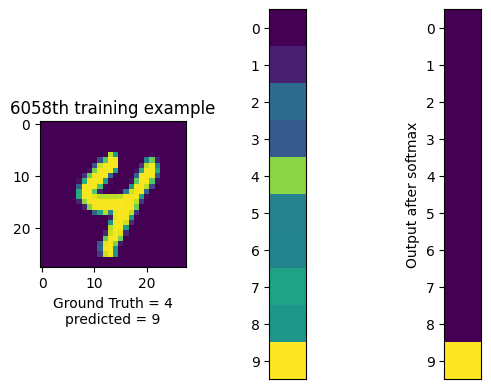

Logits output =  [-3132.00038354 -1922.54749206  1635.46894014   714.07398765
  8143.05038804  2922.68506161  3046.09994545  4709.96493074
  4096.07908933 10514.90218801]
Softmax output =  [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
Loss value for this example =  nan

======= Epoch : 6 =======
Initial Loss = nan
45000
Loss after training = nan

======= Epoch : 7 =======
Initial Loss = nan
46000
Loss after training = nan


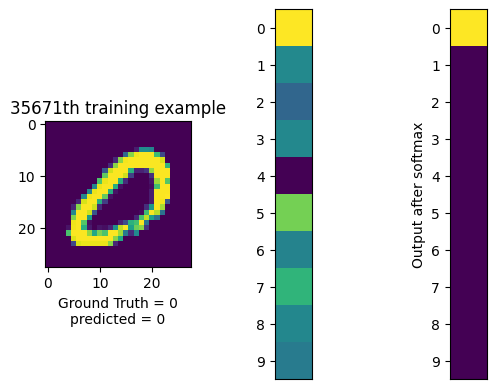

Logits output =  [ 12731.92818303    645.74978866  -2594.18812043    542.93144002
 -10111.93368329   7978.85471573    134.49807134   4856.48825877
    420.80165471   -585.78676903]
Softmax output =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 8 =======
Initial Loss = nan
47000
Loss after training = nan

======= Epoch : 9 =======
Initial Loss = nan
48000
Loss after training = nan

======= Epoch : 10 =======
Initial Loss = nan
49000
Loss after training = nan


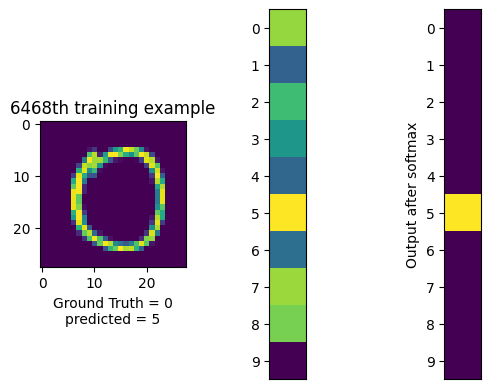

Logits output =  [ 4793.45841511 -3433.12131286  2437.64932241   -92.34287779
 -3174.27449781  7280.15651546 -2606.59342542  4948.51227434
  4079.8328443  -8343.28375778]
Softmax output =  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 11 =======
Initial Loss = nan
50000
Loss after training = nan

======= Epoch : 12 =======
Initial Loss = nan
51000
Loss after training = nan

======= Epoch : 13 =======
Initial Loss = nan
52000
Loss after training = nan

======= Epoch : 14 =======
Initial Loss = nan
53000
Loss after training = nan


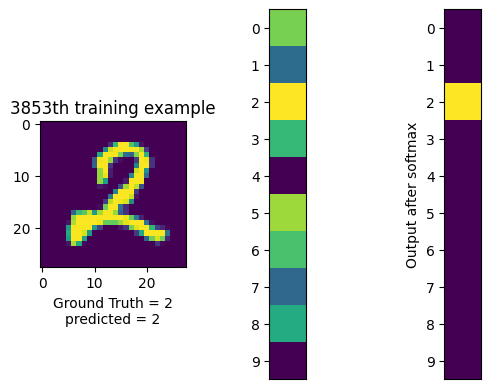

Logits output =  [10118.29203178  4244.59371675 12868.70707336  8498.59610205
  -425.05584099 10935.06655232  9026.17208465  4061.57299517
  7732.50695615  -445.29907014]
Softmax output =  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 15 =======
Initial Loss = nan
54000
Loss after training = nan

======= Epoch : 16 =======
Initial Loss = nan
55000
Loss after training = nan

======= Epoch : 17 =======
Initial Loss = nan
56000
Loss after training = nan

======= Epoch : 18 =======
Initial Loss = nan
57000
Loss after training = nan

======= Epoch : 19 =======
Initial Loss = nan
58000
Loss after training = nan

======= Epoch : 20 =======
Initial Loss = nan
59000
Loss after training = nan


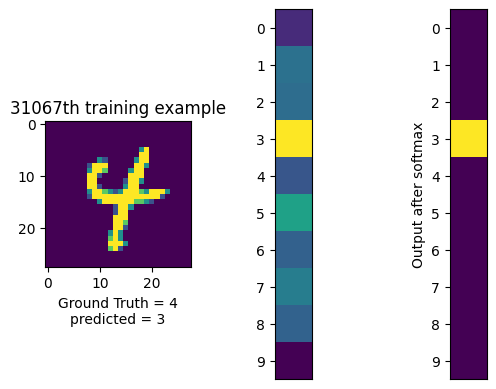

Logits output =  [-1130.27139268  -304.1289573   -355.80564512  1772.92282888
  -645.28821483   356.37516633  -503.93793899  -135.20464477
  -490.3123173  -1533.0379044 ]
Softmax output =  [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan

======= Epoch : 21 =======
Initial Loss = nan
0
Loss after training = nan

======= Epoch : 22 =======
Initial Loss = nan
1000
Loss after training = nan

======= Epoch : 23 =======
Initial Loss = nan
2000
Loss after training = nan

======= Epoch : 24 =======
Initial Loss = nan
3000
Loss after training = nan

======= Epoch : 25 =======
Initial Loss = nan
4000
Loss after training = nan

======= Epoch : 26 =======
Initial Loss = nan
5000
Loss after training = nan

======= Epoch : 27 =======
Initial Loss = nan
6000
Loss after training = nan

======= Epoch : 28 =======
Initial Loss = nan
7000
Loss after training = nan


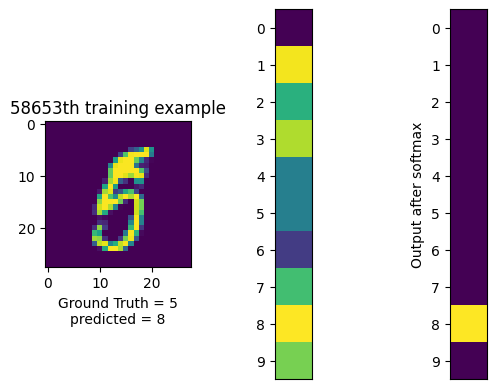

Logits output =  [-1310.87248928  2686.12114093  1283.3779403   2283.86285318
   446.59103493   441.14556108  -594.32989955  1531.98863679
  2764.11535926  1921.36052678]
Softmax output =  [0.00000000e+000 1.34134767e-034 0.00000000e+000 2.68526215e-209
 0.00000000e+000 0.00000000e+000 0.00000000e+000 0.00000000e+000
 1.00000000e+000 0.00000000e+000]
Loss value for this example =  nan

======= Epoch : 29 =======
Initial Loss = nan
8000
Loss after training = nan

======= Epoch : 30 =======
Initial Loss = nan
9000
Loss after training = nan

======= Epoch : 31 =======
Initial Loss = nan
10000
Loss after training = nan

======= Epoch : 32 =======
Initial Loss = nan
11000
Loss after training = nan

======= Epoch : 33 =======
Initial Loss = nan
12000
Loss after training = nan

======= Epoch : 34 =======
Initial Loss = nan
13000
Loss after training = nan

======= Epoch : 35 =======
Initial Loss = nan
14000
Loss after training = nan

======= Epoch : 36 =======
Initial Loss = nan
15000
Loss aft

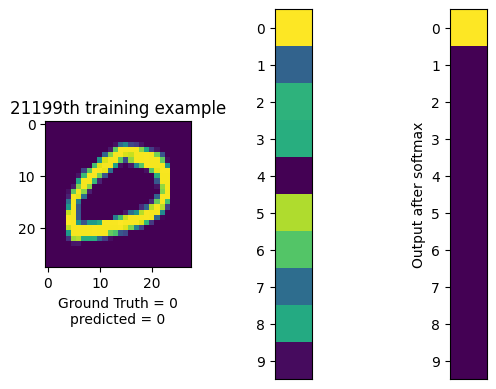

Logits output =  [ 8522.51807273 -1356.59877164  3396.71183529  3140.61822091
 -5935.73778326  6808.92726253  4661.41465529  -760.09081136
  2904.12297439 -5495.16018767]
Softmax output =  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Loss value for this example =  nan


In [15]:
examples = 10
epochs = 40
last_epoch = -1
learning_rate = 0.00003
for epoch in range(epochs):
    print(f"\n======= Epoch : {epoch+1} =======")
    print(f"Initial Loss = {MnistClassificationModel.get_loss()}")
    MnistClassificationModel.reset_gradient()
    batchx, batchy = batch_generator_1000()
    for tx, ty in zip(batchx, batchy):
        MnistClassificationModel.see_dataset_for_training(tx, ty)
        
    MnistClassificationModel.make_model_learn(learning_rate/1000)
    print(f"Loss after training = {MnistClassificationModel.get_loss()}")

    log_epoch = np.floor(np.log(epoch + 1)/np.log(epochs)*examples)
    if log_epoch != last_epoch:
        model_tester(print_outputs=True)
    last_epoch = log_epoch


array([[ 3958.98786083],
       [-1446.14178868],
       [ 1846.03421326],
       [ 2421.01738702],
       [-1185.18354877],
       [ 7619.33204859],
       [ 4412.78373193],
       [ 1670.62921187],
       [ 2039.92531966],
       [-4785.876043  ]])

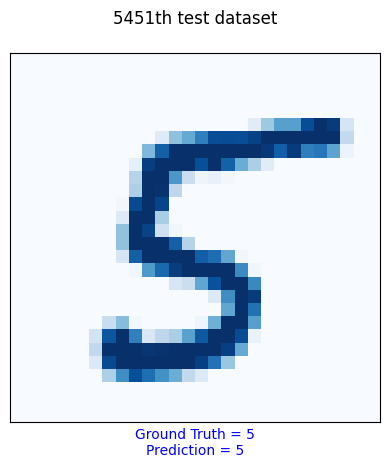

In [13]:
def choose_random_test():
    limit = len(testy)
    random_number = np.random.randint(0, limit)
    sample_X = testx[random_number]
    sample_y = testy[random_number]
    return sample_X, sample_y, random_number
    
def choose_random_and_test_model(log_output=True):
    xx, yy, n = choose_random_test()
    prediction = MnistClassificationModel(xx)
    prediction_number = np.argmax(prediction)

    correct = prediction_number == yy
    colour = 'blue' if correct else 'red'
    plt.imshow(xx, cmap="Blues")
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(f"Ground Truth = {yy}\nPrediction = {prediction_number}", color=colour)
    plt.title(f"{n}th test dataset\n")
    return np.reshape(prediction, (-1,1))
    
choose_random_and_test_model() 

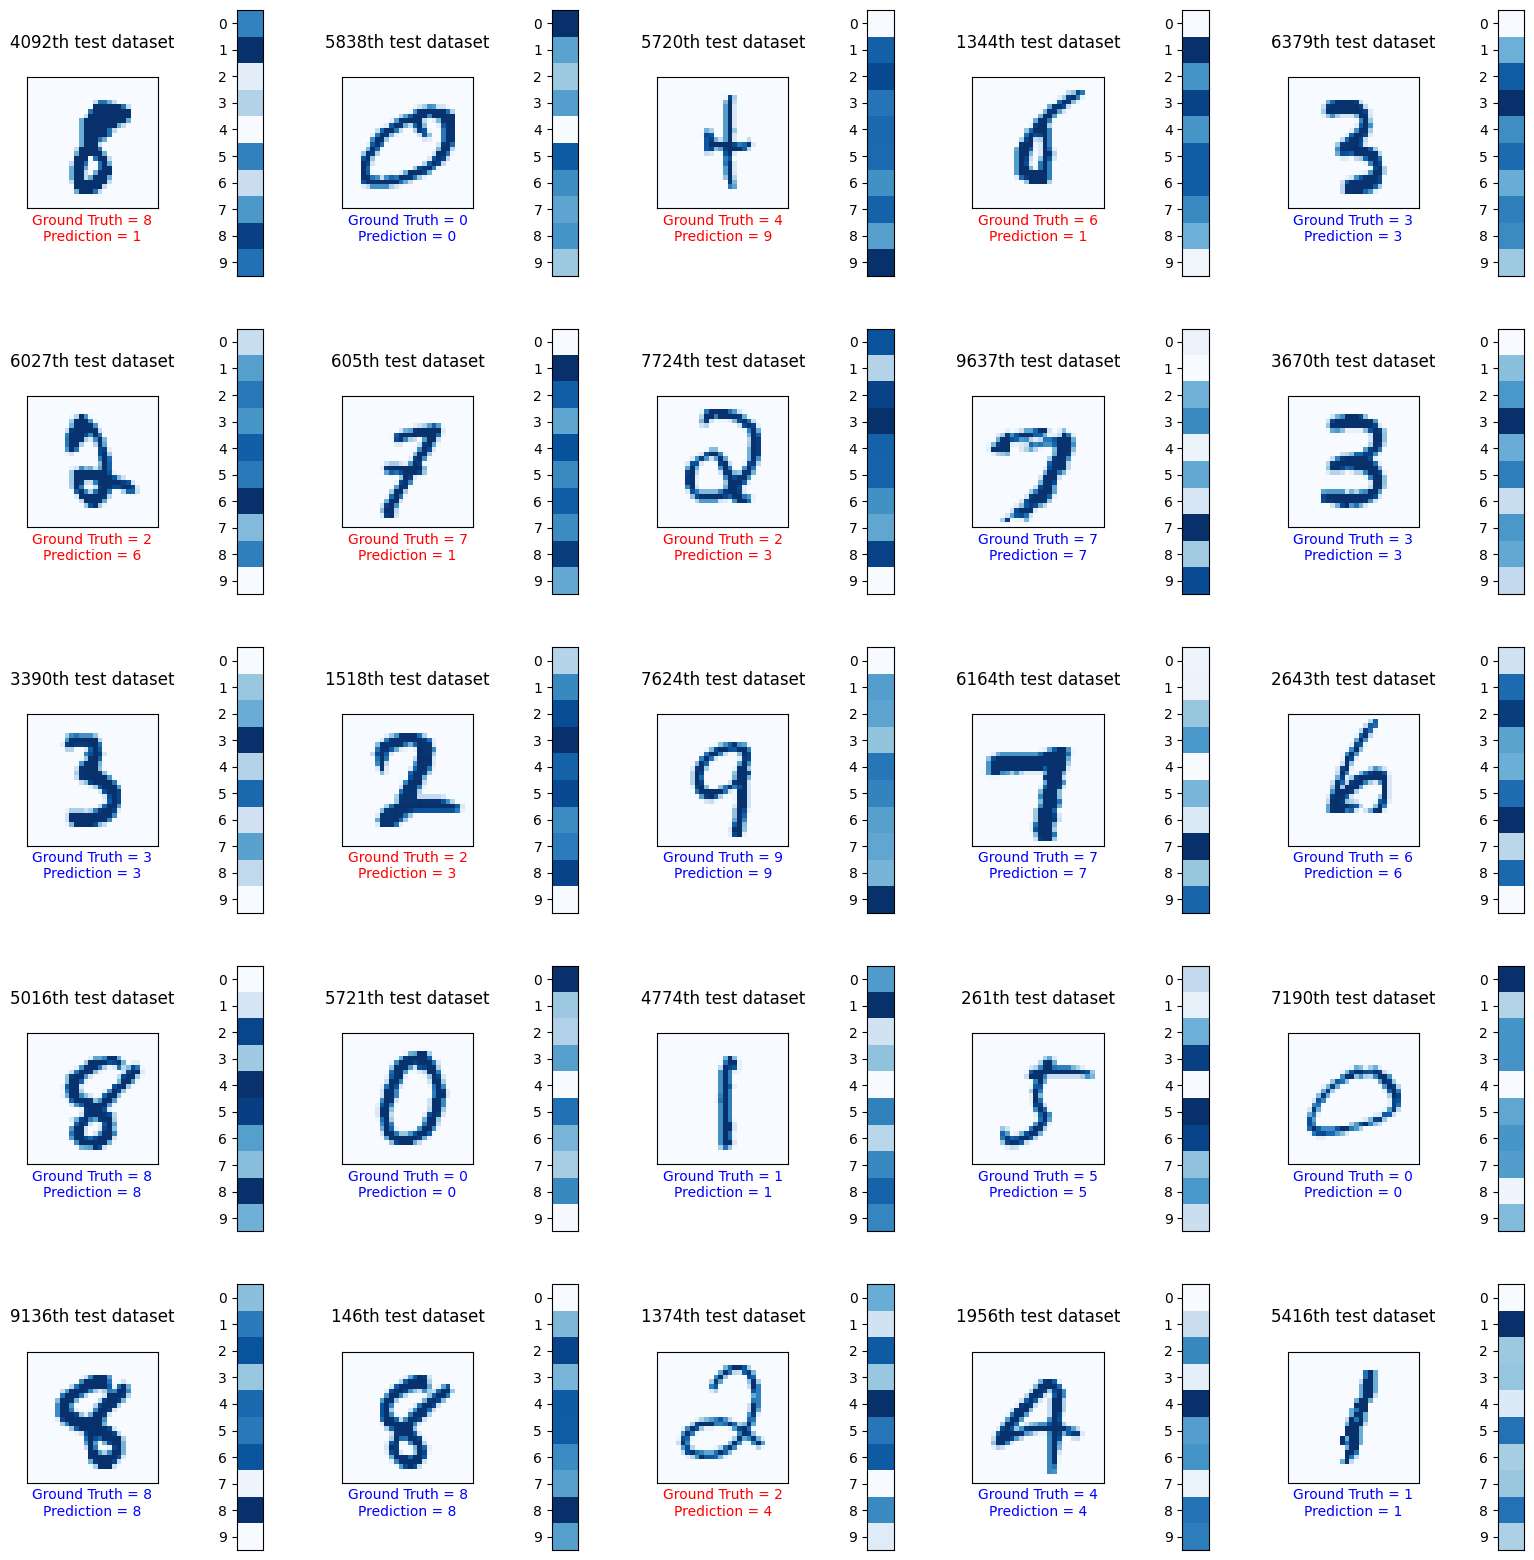

In [16]:
plt.figure(figsize=(20,20))
for i in range(25):
    plt.subplot(5,10, i*2+1)
    prediction = choose_random_and_test_model()

    plt.subplot(5, 10, i*2+2)
    plt.imshow(prediction, cmap='Blues')
    plt.yticks(np.arange(10))
    plt.xticks([])

plt.savefig("Output.png")
    